<a href="https://colab.research.google.com/github/akhii-leesh/Brain-Tumour-Detection-with-Pytorch/blob/main/BrainTumourDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 73% 11.0M/15.1M [00:00<00:00, 111MB/s]
100% 15.1M/15.1M [00:00<00:00, 132MB/s]


In [ ]:
!unzip brain-mri-images-for-brain-tumor-detection.zip

Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_datase

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
path = '/content/brain_tumor_dataset'
negative = os.listdir(path + '/no')
positive = os.listdir(path + '/yes')
print(f"MRI scans with no tumour = {len(negative)}")
print(f"MRI scans with tumour = {len(positive)}")

MRI scans with no tumour = 98
MRI scans with tumour = 155


In [ ]:
# checking sizes of images
rnd = [5,10,25]
for i in range(len(rnd)):
  rndimg = Image.open(path + '/yes/' + positive[rnd[i]])
  print(rndimg.size)

(864, 938)
(630, 630)
(232, 309)


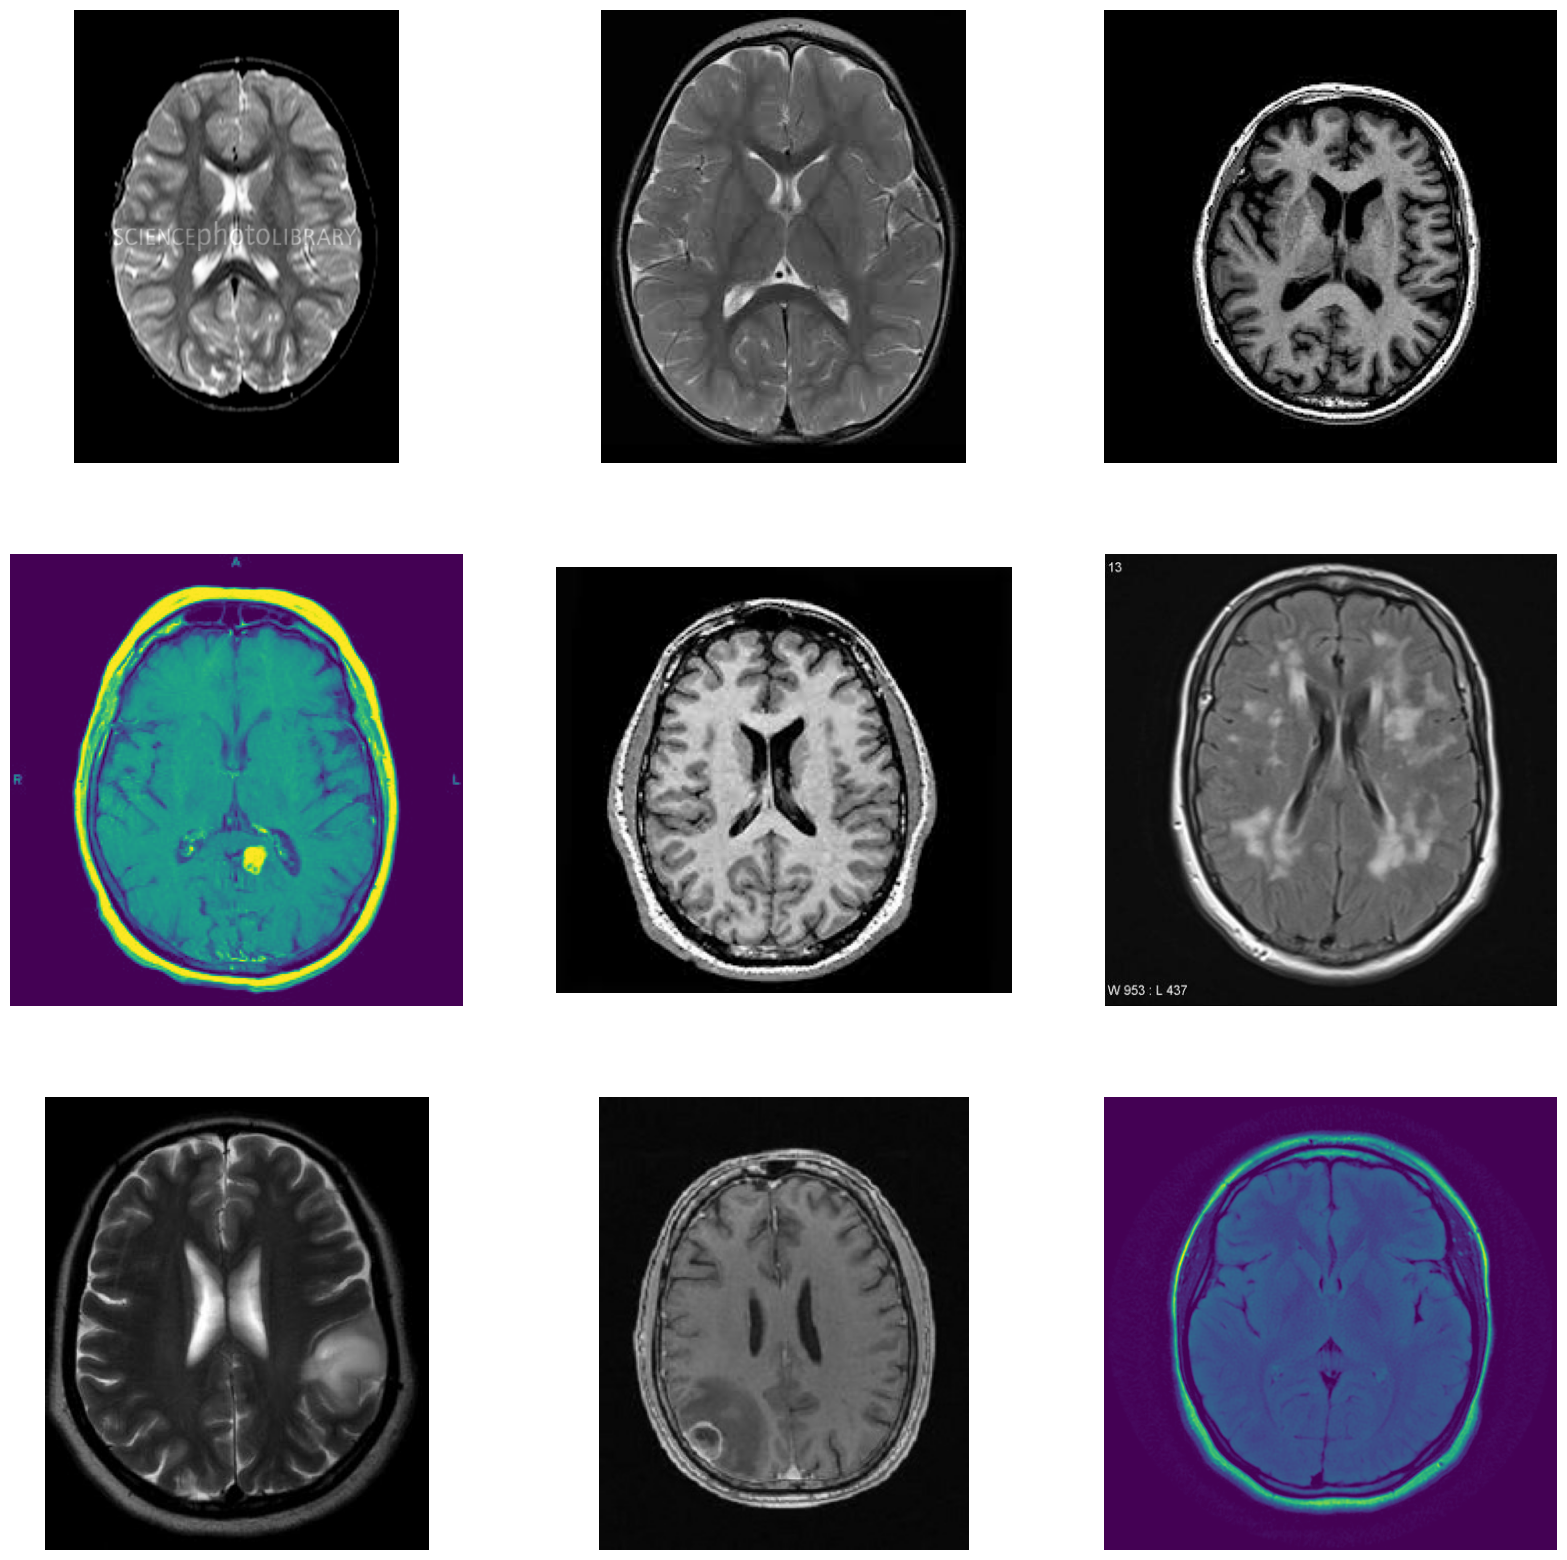

In [ ]:
# no tumour MRI scans plotted
fig = plt.figure(figsize=(20,20))
for i in range(9):
  plt.subplot(3,3,i+1)
  img = Image.open(path + '/no/' + negative[i])
  plt.imshow(img)
  plt.axis('off')

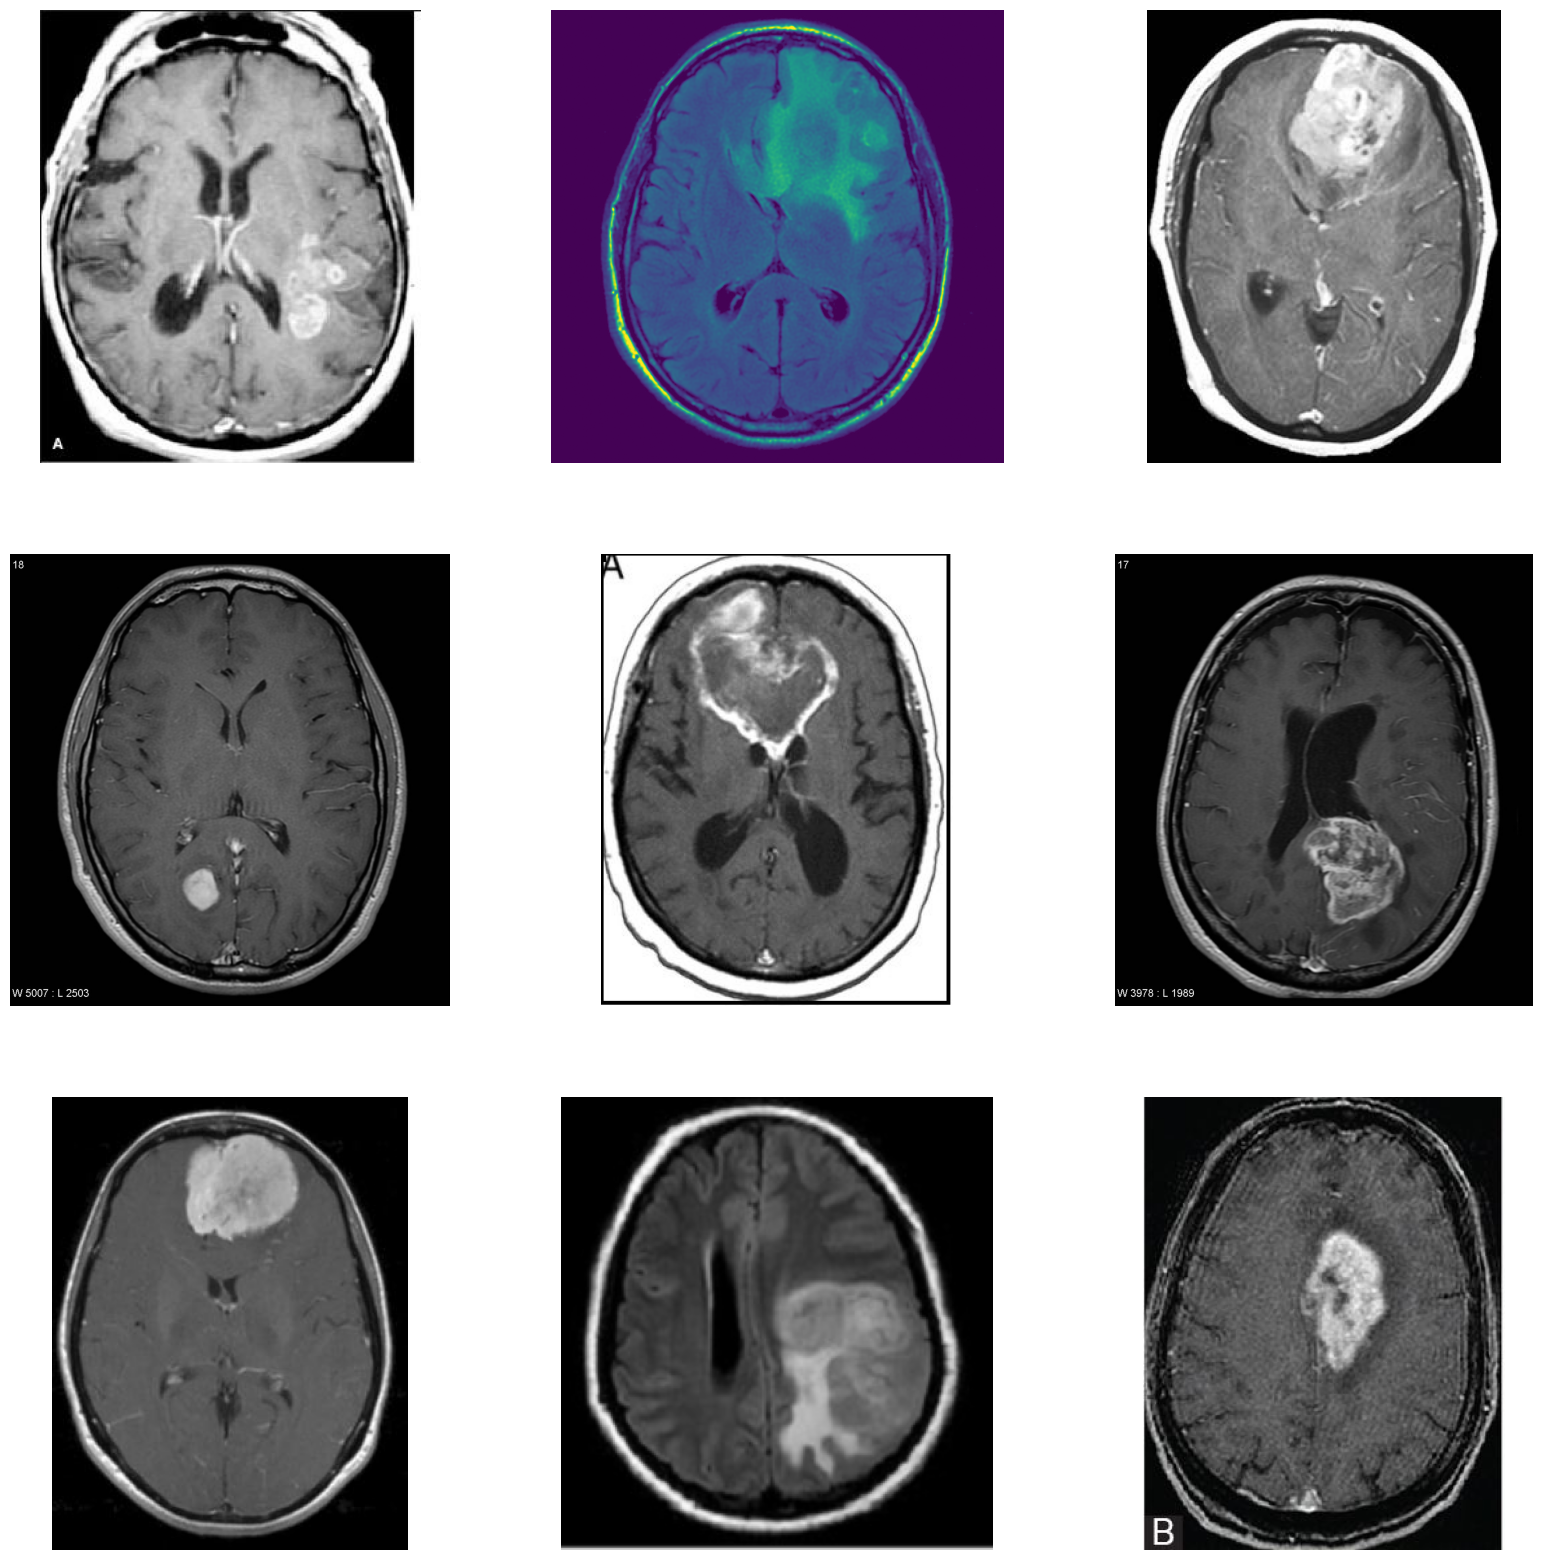

In [ ]:
# tumour MRI scans plotted
fig = plt.figure(figsize=(20,20))
for i in range(9):
  plt.subplot(3,3,i+1)
  img = Image.open(path + '/yes/' + positive[i])
  plt.imshow(img)
  plt.axis('off')

In [ ]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Gather all image paths and corresponding labels
        self.image_paths = []
        self.labels = []

        for label, subdir in enumerate(['no', 'yes']):
            subdir_path = os.path.join(root_dir, subdir)
            for fname in os.listdir(subdir_path):
                if fname.endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(subdir_path, fname))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

In [ ]:
dataset = BrainTumorDataset(root_dir=path, transform=transformations)

In [ ]:
from torch.utils.data import random_split

In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
for images,labels in train_loader:
  print(images.shape)
  print(labels.shape)
  break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [ ]:
from torchvision import models

In [ ]:
model_ft = models.resnet50(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=1e-4, weight_decay=1e-5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s]


In [ ]:
def train_model(model,num_epochs,train_loader,train_loss):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss.append(running_loss/len(train_loader))
        accuracy = 100 * correct / total

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')

    print("Training complete")

In [ ]:
def val_loop(model,test_loader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy
    val_loss /= len(test_loader)
    accuracy = 100 * correct / total

    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [ ]:
num_epochs = 500
train_loss = []

In [ ]:
train_model = train_model(model_ft,num_epochs,train_loader,train_loss)

Epoch [1/500], Loss: 0.7054, Accuracy: 46.85%
Epoch [2/500], Loss: 0.6721, Accuracy: 58.04%
Epoch [3/500], Loss: 0.6880, Accuracy: 51.05%
Epoch [4/500], Loss: 0.6684, Accuracy: 61.54%
Epoch [5/500], Loss: 0.6543, Accuracy: 64.34%
Epoch [6/500], Loss: 0.6422, Accuracy: 72.03%
Epoch [7/500], Loss: 0.6233, Accuracy: 76.22%
Epoch [8/500], Loss: 0.6237, Accuracy: 73.43%
Epoch [9/500], Loss: 0.6056, Accuracy: 77.62%
Epoch [10/500], Loss: 0.5921, Accuracy: 74.13%
Epoch [11/500], Loss: 0.5853, Accuracy: 75.52%
Epoch [12/500], Loss: 0.5687, Accuracy: 79.72%
Epoch [13/500], Loss: 0.5611, Accuracy: 79.02%
Epoch [14/500], Loss: 0.5738, Accuracy: 79.02%
Epoch [15/500], Loss: 0.5637, Accuracy: 80.42%
Epoch [16/500], Loss: 0.5338, Accuracy: 83.92%
Epoch [17/500], Loss: 0.5436, Accuracy: 81.82%
Epoch [18/500], Loss: 0.5059, Accuracy: 82.52%
Epoch [19/500], Loss: 0.5381, Accuracy: 76.22%
Epoch [20/500], Loss: 0.5404, Accuracy: 78.32%
Epoch [21/500], Loss: 0.4896, Accuracy: 84.62%
Epoch [22/500], Loss: 

In [ ]:
val_loop(model_ft,test_loader)

Validation Loss: 0.2843, Accuracy: 91.67%


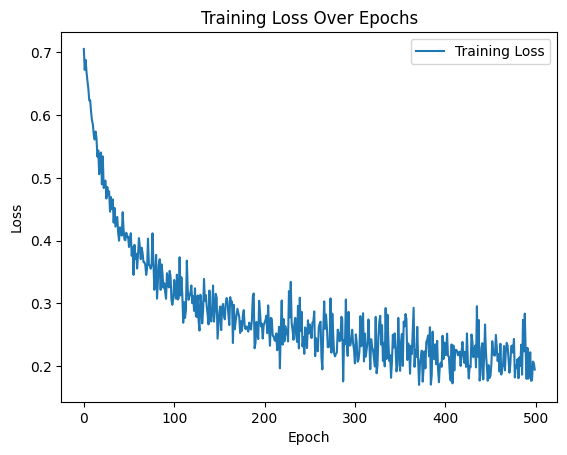

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()